<a href="https://colab.research.google.com/github/Svetorus/Computer_vision/blob/master/DP_HW_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Синтезирование лиц LFW датасета с помощью глубокой сверточной генеративной модели (DCGAN)

In [0]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from math import sqrt as sq
import tensorflow as tf
import numpy as np
import collections
import os
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (Input, InputLayer, Lambda, Conv2D, 
                                     BatchNormalization, Flatten, Dense, Reshape, 
                                     Conv2DTranspose, Activation, LeakyReLU, Dropout)

In [0]:
# Загрузка LFW Датасета

train_ds, ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split='train',)

In [0]:
ds_info.features['image']

Image(shape=(250, 250, 3), dtype=tf.uint8)

In [0]:
N_SHOW = 30 # Количество выводимых изображений
INPUT_DIM = 100 # Размерность латентного вектора
NUM_EPOCHS = 20
HALF_BATCH_SIZE = 16  # размер серии генерируемых изображений
BATCH_SIZE = HALF_BATCH_SIZE * 2  # размер серии с учетом реальных изображений
LEARNING_RATE = 0.0004

In [0]:
# Принимает на вход объект tensorflow OptionsDataset и выводит матрицу изображений с метками с заданным размером
def plot_images_grid(data, n):
    samples = data.take(n)
    plt.figure(figsize=(16,12))
    
    # В данном датасете [0] элементом являются метки класса, [1] - само изображение
    for i, sample in enumerate(samples):
        plt.subplot(sq(n)+1,sq(n),i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(sample[1])
        plt.xlabel(sample[0].numpy().decode().replace("_", " "))
    plt.show()

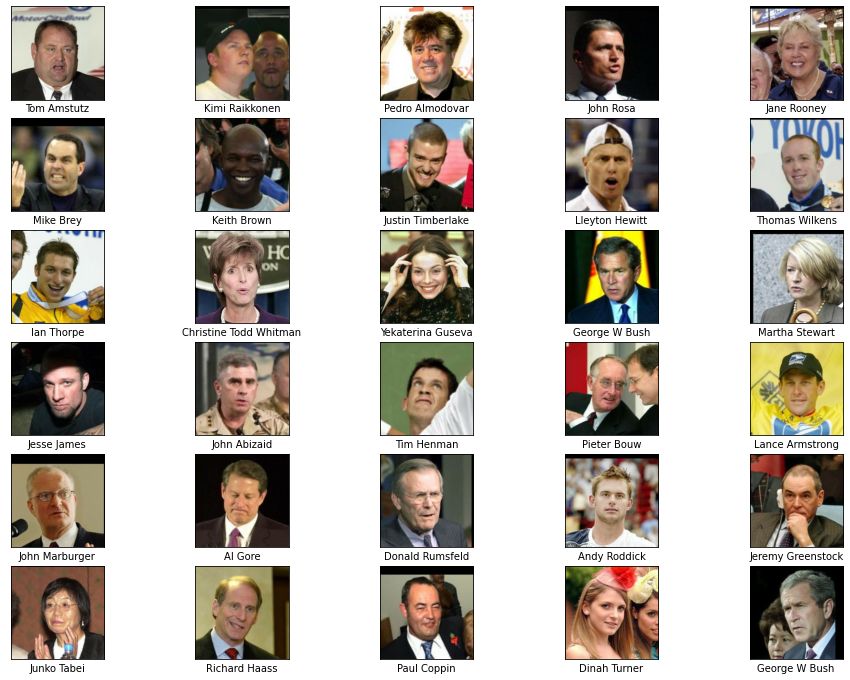

In [0]:
plot_images_grid(train_ds, N_SHOW)

In [0]:
def prepare(label, img):
    img = tf.image.resize(img, [224, 224]) # корректировка размерности входа в модель
    return label, (tf.cast(img, tf.float32) - 127.5) / 127.5  # стандартизация изображения

train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(prepare)

### Построение модели DCGAN

In [0]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256*7*7, activation='relu'),
    tf.keras.layers.Reshape((7, 7, 256)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),  
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),  
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(), 
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(16, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

# Функция выводаа изображений во время обучения
def plot_images(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        new_img = (samples[j, ...] * 127.5) + 127.5
        new_img = (tf.cast(new_img, tf.int16))
        ax.imshow(new_img)
        plt.xticks([]), plt.yticks([])
    plt.show()

In [0]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

[Step  0] D Loss: 0.8988; G Loss: 0.5124


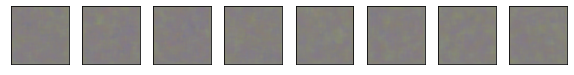

[Step 1000] D Loss: 5.2758; G Loss: 16.1360


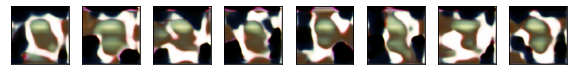

[Step 2000] D Loss: 5.3115; G Loss: 26.0573


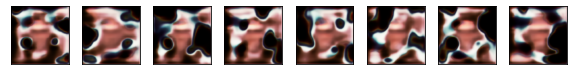

[Step 3000] D Loss: 1.9756; G Loss: 10.7995


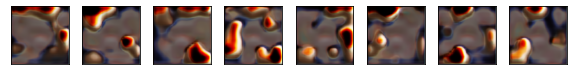

[Step 4000] D Loss: 0.0303; G Loss: 15.7711


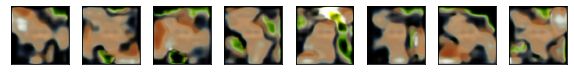

[Step 5000] D Loss: 0.3086; G Loss: 14.7971


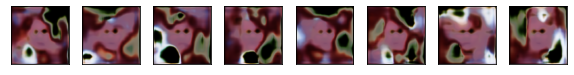

[Step 6000] D Loss: 0.3785; G Loss: 9.7068


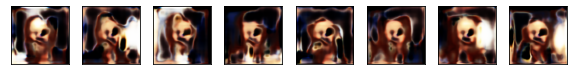

[Step 7000] D Loss: 0.8312; G Loss: 11.4447


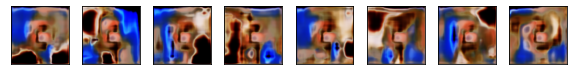

[Step 8000] D Loss: 3.6570; G Loss: 11.1288


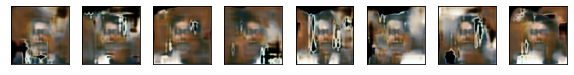

[Step 9000] D Loss: 2.0090; G Loss: 5.8571


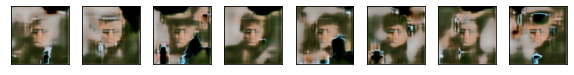

[Step 10000] D Loss: 8.5355; G Loss: 0.0723


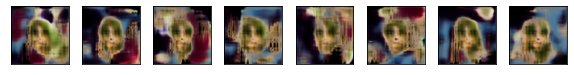

[Step 11000] D Loss: 0.8390; G Loss: 14.6968


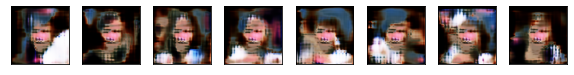

[Step 12000] D Loss: 1.0773; G Loss: 4.1585


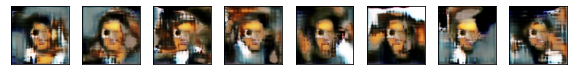

[Step 13000] D Loss: 0.2180; G Loss: 2.2983


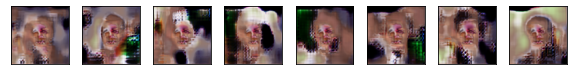

[Step 14000] D Loss: 0.4620; G Loss: 4.5282


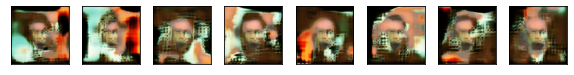

[Step 15000] D Loss: 1.4204; G Loss: 5.0552


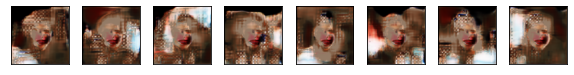

[Step 16000] D Loss: 0.0001; G Loss: 29.6743


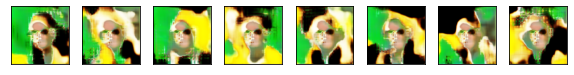

CPU times: user 51min 48s, sys: 6min 58s, total: 58min 46s
Wall time: 2h 1min 31s


In [0]:
%%time
for step, (_, true_images) in enumerate(train_ds):
    
    # Шаг тренеровки дискриминатора
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Шаг тренеровки генератора
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Вывод промежуточных результатов
    
    if step % 1000 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_images(syntetic_images)

## Тестирование свёрточного генератора

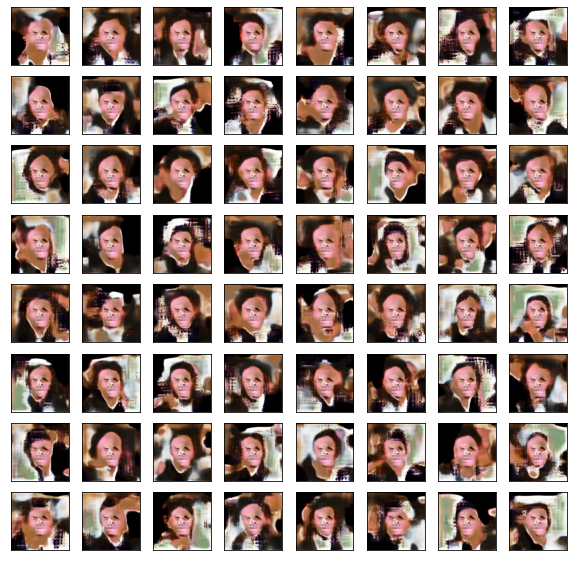

In [0]:
noise = np.random.normal(0, 1, (64, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_images(syntetic_images)

## Интерполяция в латентном пространстве

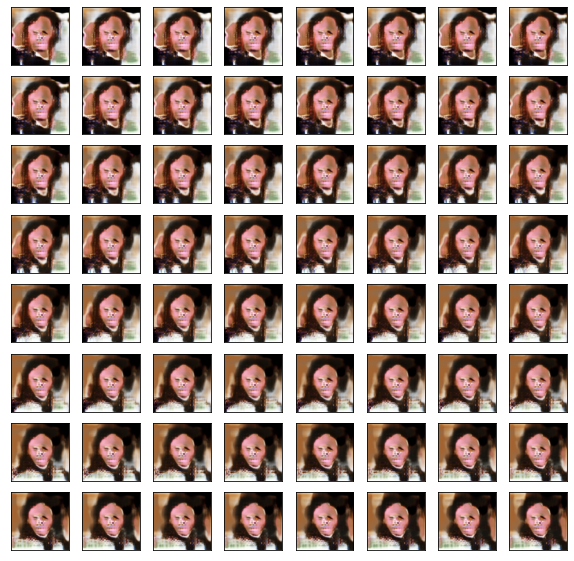

In [0]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 64)
syntetic_images = generator.predict(noise)
plot_images(syntetic_images)